# Preprocessing

In [1]:
import pandas as pd
import numpy as np
import os
import sys
import argparse
import logging
import json
import re
import time
import subprocess


In [27]:
df = pd.read_csv('/home/zliu36/codes/LuCode/CSC8824/22-12-submission.csv')

In [28]:
# only keep the last 3 columns
df = df.iloc[:, -3:]

In [38]:
df.head()

,title,selftext,stance
0,Apple is China's bitch,Apple is China's bitch \n[Apple made secret ...,anti-china
1,[Day 1] China Sorrows,[Day 1] China Sorrows Just a quick pre-text. T...,pro-china
2,Apple decides to take the side of oppression a...,Apple decides to take the side of oppression a...,anti-china
3,#加速主义,"#加速主义 During the reign of trump, make ""acceler...",pro-china
4,my chinese class wants to thank our professor ...,my chinese class wants to thank our professor ...,pro-china


In [11]:
# rename selftext to text
df.rename(columns={'selftext': 'text'}, inplace=True)

In [39]:
# value of stance
df['stance'].value_counts()

stance
anti-china    861
pro-china     344
Name: count, dtype: int64

In [102]:
df

,title,selftext,stance,text,label
0,Apple is China's bitch,Apple is China's bitch \n[Apple made secret ...,anti-china,Apple is China's bitch Apple is China's bitch ...,0
1,[Day 1] China Sorrows,[Day 1] China Sorrows Just a quick pre-text. T...,pro-china,[Day 1] China Sorrows [Day 1] China Sorrows Ju...,1
2,Apple decides to take the side of oppression a...,Apple decides to take the side of oppression a...,anti-china,Apple decides to take the side of oppression a...,0
3,#加速主义,"#加速主义 During the reign of trump, make ""acceler...",pro-china,"#加速主义 #加速主义 During the reign of trump, make ""a...",1
4,my chinese class wants to thank our professor ...,my chinese class wants to thank our professor ...,pro-china,my chinese class wants to thank our professor ...,1
...,...,...,...,...,...
1200,Looks like a lot of Asian American are realizi...,Looks like a lot of Asian American are realizi...,anti-china,Looks like a lot of Asian American are realizi...,0
1201,The Chinese Spy!,The Chinese Spy! When Grace was explaining how...,anti-china,The Chinese Spy! The Chinese Spy! When Grace w...,0
1202,What are the most fundamental distinctions in ...,What are the most fundamental distinctions in ...,anti-china,What are the most fundamental distinctions in ...,0
1203,I do knot now why people is being hating on th...,I do knot now why people is being hating on th...,anti-china,I do knot now why people is being hating on th...,0


# Refactor all classifiers into reusable classes/functions


In [45]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from imblearn.over_sampling import SMOTE
import transformers

# -------------------------------
# 1. Evaluation Utility
# -------------------------------
def evaluate_metrics(y_true, y_pred, model_name="model"):
    return pd.DataFrame([{
        'precision': precision_score(y_true, y_pred, average='macro'),
        'recall': recall_score(y_true, y_pred, average='macro'),
        'f1': f1_score(y_true, y_pred, average='macro'),
        'accuracy': accuracy_score(y_true, y_pred)
    }], index=[model_name])

# -------------------------------
# 2. Preprocessing Utility with SMOTE
# Input column: "text" (created from title+selftext if not exists)
# Label column: "label"
# -------------------------------
def preprocess_data(df, text_col="text", label_col="stance", apply_smote=True):
    # Create text column if it doesn't exist
    df_copy = df.copy()
    if text_col not in df_copy.columns and "title" in df_copy.columns and "selftext" in df_copy.columns:
        df_copy[text_col] = df_copy["title"] + " " + df_copy["selftext"]
    
    # Handle text data
    X = df_copy[text_col]
    y = df_copy[label_col]
    
    # Encode labels 
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    
    # Split data first
    X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42)
    
    return (X_train, X_test, y_train, y_test), le

# -------------------------------
# 3. Modified Classifier Functions with SMOTE
# -------------------------------
def run_logistic_regression(X_train, X_test, y_train, y_test):
    # Create pipeline with TF-IDF
    pipeline = Pipeline([
        ("tfidf", TfidfVectorizer(max_features=5000))
    ])
    
    # Transform the text data
    X_train_tfidf = pipeline.fit_transform(X_train)
    X_test_tfidf = pipeline.transform(X_test)
    
    # Apply SMOTE on the transformed training data
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_tfidf, y_train)
    
    # Train classifier on balanced data
    classifier = LogisticRegression(max_iter=1000)
    classifier.fit(X_train_resampled, y_train_resampled)
    
    # Predict and evaluate
    y_pred = classifier.predict(X_test_tfidf)
    return evaluate_metrics(y_test, y_pred, model_name="LogisticRegression+TFIDF+SMOTE")

def run_svm(X_train, X_test, y_train, y_test):
    # Create pipeline with TF-IDF
    pipeline = Pipeline([
        ("tfidf", TfidfVectorizer(max_features=5000))
    ])
    
    # Transform the text data
    X_train_tfidf = pipeline.fit_transform(X_train)
    X_test_tfidf = pipeline.transform(X_test)
    
    # Apply SMOTE on the transformed training data
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_tfidf, y_train)
    
    # Train classifier on balanced data
    classifier = LinearSVC()
    classifier.fit(X_train_resampled, y_train_resampled)
    
    # Predict and evaluate
    y_pred = classifier.predict(X_test_tfidf)
    return evaluate_metrics(y_test, y_pred, model_name="SVM+TFIDF+SMOTE")

def run_mlp(X_train, X_test, y_train, y_test):
    # Create pipeline with TF-IDF
    pipeline = Pipeline([
        ("tfidf", TfidfVectorizer(max_features=5000))
    ])
    
    # Transform the text data
    X_train_tfidf = pipeline.fit_transform(X_train)
    X_test_tfidf = pipeline.transform(X_test)
    
    # Apply SMOTE on the transformed training data
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_tfidf, y_train)
    
    # Train classifier on balanced data
    classifier = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
    classifier.fit(X_train_resampled, y_train_resampled)
    
    # Predict and evaluate
    y_pred = classifier.predict(X_test_tfidf)
    return evaluate_metrics(y_test, y_pred, model_name="MLP+TFIDF+SMOTE")

# LSTM
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import re
from collections import Counter
import numpy as np

# -------------------------------
# Preprocessing utilities
# -------------------------------
def preprocess_text(text):
    text = re.sub(r'\W+', ' ', text.lower())
    return text.strip().split()

def build_vocab(texts, vocab_size=1000):
    word_counts = Counter(word for doc in texts for word in doc)
    vocab = {word: i + 1 for i, (word, _) in enumerate(word_counts.most_common(vocab_size))}
    vocab['<PAD>'] = 0
    return vocab

def encode(text, vocab, max_len=50):
    seq = [vocab.get(w, 0) for w in text][:max_len]
    return seq + [0] * (max_len - len(seq))

class TextDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.LongTensor(X)
        self.y = torch.LongTensor(y)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# -------------------------------
# LSTM model
# -------------------------------
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim=50, hidden_dim=64, num_classes=2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)
    def forward(self, x):
        embedded = self.embedding(x)
        _, (h_n, _) = self.lstm(embedded)
        out = self.fc(h_n[-1])
        return out

# -------------------------------
# Training + Evaluation with SMOTE
# -------------------------------
def run_lstm(df, batch_size=2, max_vocab=1000, max_len=50, epochs=10):
    # Combine title and selftext if they exist separately
    if "text" not in df.columns and "title" in df.columns and "selftext" in df.columns:
        df["text"] = df["title"] + " " + df["selftext"]
    
    texts = df["text"].apply(preprocess_text)
    labels = df["stance"]

    vocab = build_vocab(texts, vocab_size=max_vocab)
    encoded_texts = [encode(t, vocab, max_len=max_len) for t in texts]
    encoded_array = np.array(encoded_texts)

    label_enc = LabelEncoder()
    encoded_labels = label_enc.fit_transform(labels)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(encoded_array, encoded_labels, test_size=0.3, random_state=42)
    
    # Reshape for SMOTE (SMOTE requires 2D array)
    orig_shape = X_train.shape
    X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
    
    # Apply SMOTE
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_reshaped, y_train)
    
    # Reshape back to original format for LSTM
    X_train_resampled = X_train_resampled.reshape(-1, orig_shape[1])
    
    # Create dataloaders
    train_loader = DataLoader(TextDataset(X_train_resampled, y_train_resampled), batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(TextDataset(X_test, y_test), batch_size=batch_size)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = LSTMClassifier(len(vocab), num_classes=len(label_enc.classes_)).to(device)
    
    # Use weighted loss to further address class imbalance
    class_weights = torch.tensor([1.0, len(y_train[y_train==0])/len(y_train[y_train==1])]).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    model.train()
    for _ in range(epochs):
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()

    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            preds = model(X_batch).argmax(dim=1).cpu().numpy()
            y_pred.extend(preds)
            y_true.extend(y_batch.numpy())

    return evaluate_metrics(y_true, y_pred, "LSTM+SMOTE")

# BERT
from transformers import BertTokenizerFast, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import numpy as np
import evaluate

# -------------------------------
# Metric function for Trainer
# -------------------------------
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {
        "accuracy": evaluate.load("accuracy").compute(predictions=predictions, references=labels)["accuracy"],
        "f1": evaluate.load("f1").compute(predictions=predictions, references=labels, average="macro")["f1"],
        "precision": evaluate.load("precision").compute(predictions=predictions, references=labels, average="macro")["precision"],
        "recall": evaluate.load("recall").compute(predictions=predictions, references=labels, average="macro")["recall"]
    }

# -------------------------------
# Full BERT training wrapper with class weights for imbalance
# -------------------------------
def run_bert(df, epochs=3, batch_size=2):
    # Combine title and selftext if necessary
    if "text" not in df.columns and "title" in df.columns and "selftext" in df.columns:
        df["text"] = df["title"] + " " + df["selftext"]
    
    # Handle class imbalance using class weights
    label_enc = LabelEncoder()
    df["label"] = label_enc.fit_transform(df["stance"])
    
    # Calculate class weights for weighted loss
    labels = df["label"].values
    class_weights = len(labels) / (len(np.unique(labels)) * np.bincount(labels))
    class_weights = torch.tensor(class_weights, dtype=torch.float)
    
    # Create datasets
    dataset = Dataset.from_pandas(df[["text", "label"]])
    dataset = dataset.train_test_split(test_size=0.3, seed=42)
    
    tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
    
    def tokenize_function(example):
        return tokenizer(example["text"], padding="max_length", truncation=True, max_length=128)
    
    tokenized_dataset = dataset.map(tokenize_function, batched=True)
    
    # Create a custom model class that handles weighted loss internally
    class BertWithWeightedLoss(BertForSequenceClassification):
        def __init__(self, config, class_weights=None):
            super().__init__(config)
            self.class_weights = class_weights
            
        def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, 
                   position_ids=None, head_mask=None, inputs_embeds=None, 
                   labels=None, output_attentions=None, output_hidden_states=None, 
                   return_dict=None):
            
            return_dict = return_dict if return_dict is not None else self.config.use_return_dict
            
            outputs = self.bert(
                input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids,
                position_ids=position_ids,
                head_mask=head_mask,
                inputs_embeds=inputs_embeds,
                output_attentions=output_attentions,
                output_hidden_states=output_hidden_states,
                return_dict=return_dict,
            )
            
            pooled_output = outputs[1]
            pooled_output = self.dropout(pooled_output)
            logits = self.classifier(pooled_output)
            
            loss = None
            if labels is not None:
                if self.class_weights is not None and self.class_weights.device != labels.device:
                    self.class_weights = self.class_weights.to(labels.device)
                    
                loss_fct = nn.CrossEntropyLoss(weight=self.class_weights)
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            
            if not return_dict:
                output = (logits,) + outputs[2:]
                return ((loss,) + output) if loss is not None else output
                
            return transformers.modeling_outputs.SequenceClassifierOutput(
                loss=loss,
                logits=logits,
                hidden_states=outputs.hidden_states,
                attentions=outputs.attentions,
            )
    
    # Initialize model with class weights
    model_config = transformers.BertConfig.from_pretrained(
        "bert-base-uncased",
        num_labels=len(label_enc.classes_)
    )
    model = BertWithWeightedLoss.from_pretrained(
        "bert-base-uncased", 
        config=model_config,
        class_weights=class_weights
    )
    
    # Training arguments
    training_args = TrainingArguments(
        output_dir="./results",
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=epochs,
        evaluation_strategy="epoch",
        save_strategy="no",
        logging_dir="./logs",
        report_to="none",
        learning_rate=2e-5,
        weight_decay=0.01,
    )
    
    # Create trainer (no need for compute_loss parameter)
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_dataset["train"],
        eval_dataset=tokenized_dataset["test"],
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )
    
    trainer.train()
    bert_eval = trainer.evaluate()
    
    return pd.DataFrame([{
        "precision": bert_eval["eval_precision"],
        "recall": bert_eval["eval_recall"],
        "f1": bert_eval["eval_f1"],
        "accuracy": bert_eval["eval_accuracy"]
    }], index=["BERT+ClassWeights"])

(X_train, X_test, y_train, y_test), label_encoder = preprocess_data(df)

lr_result = run_logistic_regression(X_train, X_test, y_train, y_test)
svm_result = run_svm(X_train, X_test, y_train, y_test)
mlp_result = run_mlp(X_train, X_test, y_train, y_test)
lstm_result = run_lstm(df)
bert_result = run_bert(df)


results = pd.concat([lr_result, svm_result, mlp_result, lstm_result, bert_result])
print(results)
results.to_csv("final_results_original.csv", index=False)


Map: 100%|██████████| 362/362 [00:00<00:00, 4307.83 examples/s]
Some weights of BertWithWeightedLoss were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/zliu36/anaconda3/envs/lu310/lib/python3.10/site-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_2938198/2978338393.py:354: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
/home/zliu36/an

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.347529,0.881215,0.855382,0.873118,0.842536
2,No log,0.401227,0.886740,0.858813,0.890830,0.839143
3,No log,0.332216,0.911602,0.895527,0.899752,0.891643


/home/zliu36/anaconda3/envs/lu310/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/zliu36/anaconda3/envs/lu310/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/zliu36/anaconda3/envs/lu310/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


                                precision    recall        f1  accuracy
LogisticRegression+TFIDF+SMOTE   0.841256  0.806064  0.820834  0.864641
SVM+TFIDF+SMOTE                  0.846815  0.816165  0.829374  0.870166
MLP+TFIDF+SMOTE                  0.848591  0.832565  0.839985  0.875691
LSTM+SMOTE                       0.576512  0.595211  0.565635  0.599448
BERT+ClassWeights                0.899752  0.891643  0.895527  0.911602


In [46]:
def get_results(df):
    """
    Returns the evaluation results of different models.
    """
    lr_result = run_logistic_regression(X_train, X_test, y_train, y_test)
    svm_result = run_svm(X_train, X_test, y_train, y_test)
    mlp_result = run_mlp(X_train, X_test, y_train, y_test)
    lstm_result = run_lstm(df)
    bert_result = run_bert(df)
    # Combine results
    results = pd.concat([lr_result, svm_result, mlp_result, lstm_result, bert_result])
    return results
    print(results)


In [47]:
get_results(df)

Map: 100%|██████████| 362/362 [00:00<00:00, 4326.61 examples/s]
Some weights of BertWithWeightedLoss were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/zliu36/anaconda3/envs/lu310/lib/python3.10/site-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_2938198/2978338393.py:354: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
/home/zliu36/an

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.347529,0.881215,0.855382,0.873118,0.842536
2,No log,0.401227,0.886740,0.858813,0.890830,0.839143
3,No log,0.332216,0.911602,0.895527,0.899752,0.891643


/home/zliu36/anaconda3/envs/lu310/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/zliu36/anaconda3/envs/lu310/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/zliu36/anaconda3/envs/lu310/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


,precision,recall,f1,accuracy
LogisticRegression+TFIDF+SMOTE,0.841256,0.806064,0.820834,0.864641
SVM+TFIDF+SMOTE,0.846815,0.816165,0.829374,0.870166
MLP+TFIDF+SMOTE,0.848591,0.832565,0.839985,0.875691
LSTM+SMOTE,0.576512,0.595211,0.565635,0.599448
BERT+ClassWeights,0.899752,0.891643,0.895527,0.911602


# Encryption

## Format-Preserving Encryption (FPE)
We'll simulate FPE by using a simple Caesar cipher on alphabetic characters. This keeps structure and length intact but obfuscates the content.



### Weakest FPE

In [48]:
def apply_fpe(text, shift=3):
    def shift_char(c):
        if c.isalpha():
            base = ord('A') if c.isupper() else ord('a')
            return chr((ord(c) - base + shift) % 26 + base)
        return c
    return ''.join(shift_char(c) for c in text)

def transform_fpe(df):
    df_fpe = df.copy()
    df_fpe["text"] = (df_fpe["title"] + " " + df_fpe["selftext"]).apply(lambda x: apply_fpe(x))
    return df_fpe


### Vigenère Cipher (Polyalphabetic Substitution)

This uses a keyword to apply different shifts to different letters, making it harder to break with simple frequency analysis than a Caesar cipher. It still preserves the format (letters remain letters, case is preserved, others untouched).

In [49]:
import string

def apply_vigenere(text, keyword):
    """Applies Vigenere cipher using a keyword. Preserves case and non-alpha chars."""
    if not keyword:
        # Fallback to simple shift if keyword is empty (or handle as error)
        return apply_fpe(text, shift=0) # No shift

    keyword = keyword.lower() # Use lowercase keyword for simplicity
    key_index = 0
    encrypted_text = []

    for char in text:
        if char.isalpha():
            key_char = keyword[key_index % len(keyword)]
            shift = ord(key_char) - ord('a') # Calculate shift based on keyword char (0-25)

            base = ord('A') if char.isupper() else ord('a')
            encrypted_char_ord = (ord(char) - base + shift) % 26 + base
            encrypted_text.append(chr(encrypted_char_ord))

            key_index += 1 # Move to the next keyword character only for letters
        else:
            encrypted_text.append(char) # Keep non-alpha characters as they are

    return "".join(encrypted_text)

def transform_vigenere(df, keyword="secretkey"):
    """Applies Vigenere transformation to 'title' and 'selftext'."""
    df_fpe = df.copy()
    # Ensure columns exist and handle potential missing values (NaN)
    df_fpe["title"] = df_fpe["title"].fillna("")
    df_fpe["selftext"] = df_fpe["selftext"].fillna("")
    
    # Combine and apply Vigenere
    df_fpe["text"] = (df_fpe["title"] + " " + df_fpe["selftext"]).apply(
        lambda x: apply_vigenere(x, keyword)
    )
    df_fpe_vigenere = df_fpe.copy()
    return df_fpe_vigenere


### Full Substitution Cipher (Monoalphabetic, Custom Key)

Instead of just shifting, you map each letter to another letter based on a shuffled alphabet (the key).

In [53]:
import random
import string

def generate_substitution_key():
    """Generates a shuffled alphabet key for substitution."""
    alphabet = list(string.ascii_lowercase)
    shuffled_alphabet = random.sample(alphabet, len(alphabet))
    # Create mapping for both lower and upper case
    key_map = {lower: shuffled for lower, shuffled in zip(string.ascii_lowercase, shuffled_alphabet)}
    key_map.update({upper: shuffled.upper() for upper, shuffled in zip(string.ascii_uppercase, shuffled_alphabet)})
    return key_map

def apply_substitution(text, key_map):
    """Applies a full substitution cipher using a key map."""
    encrypted_text = []
    for char in text:
        # Substitute if the character is in our map (alphabetic), otherwise keep original
        encrypted_text.append(key_map.get(char, char))
    return "".join(encrypted_text)

def transform_substitution(df, key_map=None):
    """Applies Substitution transformation to 'title' and 'selftext'."""
    if key_map is None:
        print("Generating a new substitution key...")
        key_map = generate_substitution_key()
        # IMPORTANT: You MUST store this key_map to decrypt later!
        # For testing, we might generate one, but in practice, it should be pre-defined and kept secret.

    df_fpe = df.copy()
    df_fpe["title"] = df_fpe["title"].fillna("")
    df_fpe["selftext"] = df_fpe["selftext"].fillna("")
    
    df_fpe["text"] = (df_fpe["title"] + " " + df_fpe["selftext"]).apply(
        lambda x: apply_substitution(x, key_map)
    )
    # Optionally return the key if generated here, or assume it's managed elsewhere
    # return df_fpe, key_map
    df_fpe_fsc = df_fpe.copy()
    return df_fpe_fsc



## Differential Privacy (DP)
We’ll randomly insert noise words into the text.

In [54]:
import random

def apply_dp_noise(text, noise_words=["foo", "bar", "baz"], noise_prob=0.5):
    tokens = text.split()
    noisy_tokens = []
    for token in tokens:
        if random.random() < noise_prob:
            noisy_tokens.append(random.choice(noise_words))
        noisy_tokens.append(token)
    return ' '.join(noisy_tokens)

def transform_dp(df):
    df_dp = df.copy()
    df_dp["text"] = (df_dp["title"] + " " + df_dp["selftext"]).apply(lambda x: apply_dp_noise(x))
    return df_dp


### Method 1: Embedding-Space Gaussian Noise
Add noise to the embedding representation of each word (useful for training or pretraining models securely).

In [66]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

def apply_dp_embedding_noise(texts, noise_std=0.1):
    vectorizer = TfidfVectorizer(max_features=5000)
    tfidf_matrix = vectorizer.fit_transform(texts)
    noisy_matrix = tfidf_matrix.toarray() + np.random.normal(0, noise_std, tfidf_matrix.shape)
    return noisy_matrix, vectorizer

def transform_dp_embedding(df):
    """
    Apply embedding noise but keep the data as text strings for compatibility with other functions.
    """
    df_dp_embedding = df.copy()
    
    # Ensure we have text column
    if "text" not in df_dp_embedding.columns:
        df_dp_embedding["text"] = (df_dp_embedding["title"] + " " + df_dp_embedding["selftext"])
    
    # Instead of storing arrays, let's add noise directly to the text by:
    # 1. Adding random padding words
    # 2. Slightly modifying words while keeping their meaning intact
    
    import random
    
    # Common padding words for noise
    padding_words = ["the", "and", "or", "but", "in", "on", "at", "to", "from"]
    
    def add_embedding_noise_to_text(text, noise_level=0.1):
        """Add noise to text while keeping it as a string"""
        words = text.split()
        
        # Add random padding words
        for i in range(len(words)):
            if random.random() < noise_level:
                words.insert(i, random.choice(padding_words))
        
        # Slightly modify words (add/remove spacing or digits)
        for i in range(len(words)):
            if random.random() < noise_level and len(words[i]) > 3:
                pos = random.randint(1, len(words[i])-1)
                if random.random() < 0.5:
                    # Add a space
                    words[i] = words[i][:pos] + " " + words[i][pos:]
                else:
                    # Add a digit
                    words[i] = words[i][:pos] + str(random.randint(0, 9)) + words[i][pos:]
        
        return " ".join(words)
    
    # Apply transformation to each text
    df_dp_embedding["text"] = df_dp_embedding["text"].apply(
        lambda x: add_embedding_noise_to_text(x) if isinstance(x, str) else ""
    )
    
    return df_dp_embedding

In [56]:
df_dp_embedding = transform_dp_embedding(df)
df_dp_embedding.head()

,title,selftext,stance,text,label
0,Apple is China's bitch,Apple is China's bitch \n[Apple made secret ...,anti-china,"[0.04967141530112327, -0.013826430117118467, 0...",0
1,[Day 1] China Sorrows,[Day 1] China Sorrows Just a quick pre-text. T...,pro-china,"[-0.042375968202270325, -0.04534141083838541, ...",1
2,Apple decides to take the side of oppression a...,Apple decides to take the side of oppression a...,anti-china,"[-0.06784947304872217, -0.03054994630536529, -...",0
3,#加速主义,"#加速主义 During the reign of trump, make ""acceler...",pro-china,"[-0.014342321645892908, -0.003265590374030994,...",1
4,my chinese class wants to thank our professor ...,my chinese class wants to thank our professor ...,pro-china,"[0.034828624766681845, 0.028332359253566648, -...",1


### Method 2: Token Dropout with Privacy Budget
Randomly remove words based on a dropout probability — similar to dropout in training, but applied to input tokens.

In [57]:
def apply_dp_token_dropout(text, dropout_prob=0.3):
    tokens = text.split()
    kept_tokens = [t for t in tokens if random.random() > dropout_prob]
    return ' '.join(kept_tokens)

def transform_dp_dropout(df, dropout_prob=0.3):
    df_dp = df.copy()
    df_dp["text"] = (df_dp["title"] + " " + df_dp["selftext"]).apply(lambda x: apply_dp_token_dropout(x, dropout_prob))
    return df_dp
df_dp_dropout = transform_dp_dropout(df)
df_dp_dropout.head()

,title,selftext,stance,text,label
0,Apple is China's bitch,Apple is China's bitch \n[Apple made secret ...,anti-china,Apple Apple is China's [Apple 5-year with Chin...,0
1,[Day 1] China Sorrows,[Day 1] China Sorrows Just a quick pre-text. T...,pro-china,[Day China Sorrows [Day China Sorrows pre-text...,1
2,Apple decides to take the side of oppression a...,Apple decides to take the side of oppression a...,anti-china,Apple decides to take the oppression and prote...,0
3,#加速主义,"#加速主义 During the reign of trump, make ""acceler...",pro-china,"#加速主义 During the reign of trump, make ""acceler...",1
4,my chinese class wants to thank our professor ...,my chinese class wants to thank our professor ...,pro-china,chinese class wants to professor what christma...,1


### Method 3: Contextual Synonym Substitution (PrivText Style)
Use synonyms from WordNet (like in WLS), but substitute based on information leakage probability — i.e., target high-information words for substitution.

In [58]:
from nltk.corpus import wordnet

def get_synonym(word):
    synsets = wordnet.synsets(word)
    synonyms = list(set(lemma.name().replace("_", " ") for s in synsets for lemma in s.lemmas()))
    synonyms = [s for s in synonyms if s.lower() != word.lower()]
    return random.choice(synonyms) if synonyms else word

def apply_dp_semantic_substitution(text, replace_prob=0.3):
    tokens = text.split()
    result = []
    for token in tokens:
        if token.isalpha() and random.random() < replace_prob:
            result.append(get_synonym(token))
        else:
            result.append(token)
    return ' '.join(result)

def transform_dp_synonym(df, replace_prob=0.3):
    df_dp = df.copy()
    df_dp["text"] = (df_dp["title"] + " " + df_dp["selftext"]).apply(lambda x: apply_dp_semantic_substitution(x, replace_prob))
    return df_dp
df_dp_synonym = transform_dp_synonym(df)
df_dp_synonym.head()

,title,selftext,stance,text,label
0,Apple is China's bitch,Apple is China's bitch \n[Apple made secret ...,anti-china,orchard apple tree is China's bitch Malus pumi...,0
1,[Day 1] China Sorrows,[Day 1] China Sorrows Just a quick pre-text. T...,pro-china,[Day 1] China Sorrows [Day 1] China grief Just...,1
2,Apple decides to take the side of oppression a...,Apple decides to take the side of oppression a...,anti-china,Apple decides to take the side of oppression a...,0
3,#加速主义,"#加速主义 During the reign of trump, make ""acceler...",pro-china,"#加速主义 #加速主义 During the reign of trump, pretend...",1
4,my chinese class wants to thank our professor ...,my chinese class wants to thank our professor ...,pro-china,my Formosan class wants to thank our prof - wh...,1


## Word-Level Substitution (WLS)
We’ll replace some words with synonyms or neutral substitutions using a simple static dictionary (you can extend it later with WordNet or GloVe).

In [59]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')  # For multilingual support

from nltk.corpus import wordnet
import random

def get_synonym(word):
    synonyms = wordnet.synsets(word)
    lemmas = set(lemma.name().replace("_", " ") for s in synonyms for lemma in s.lemmas())
    lemmas.discard(word.lower())
    if lemmas:
        return random.choice(list(lemmas))
    else:
        return word

def apply_wls_auto(text, replace_prob=0.3):
    tokens = text.split()
    new_tokens = []
    for token in tokens:
        clean_token = ''.join([c for c in token if c.isalpha()])
        if clean_token and random.random() < replace_prob:
            synonym = get_synonym(clean_token)
            new_tokens.append(synonym)
        else:
            new_tokens.append(token)
    return ' '.join(new_tokens)

def transform_wls_auto(df, replace_prob=0.3):
    df_wls = df.copy()
    df_wls["text"] = (df_wls["title"] + " " + df_wls["selftext"]).apply(lambda x: apply_wls_auto(x, replace_prob))
    return df_wls



[nltk_data] Downloading package wordnet to /home/zliu36/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/zliu36/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [60]:
df_fpe = transform_fpe(df)
df_vigenere = transform_vigenere(df)
df_substitution = transform_substitution(df)
df_dp  = transform_dp(df)
df_wls = transform_wls_auto(df)
df_dp_embedding = transform_dp_embedding(df)
df_dp_dropout = transform_dp_dropout(df)
df_dp_synonym = transform_dp_synonym(df)



Generating a new substitution key...


In [61]:
df_fpe


,title,selftext,stance,text,label
0,Apple is China's bitch,Apple is China's bitch \n[Apple made secret ...,anti-china,Dssoh lv Fklqd'v elwfk Dssoh lv Fklqd'v elwfk ...,0
1,[Day 1] China Sorrows,[Day 1] China Sorrows Just a quick pre-text. T...,pro-china,[Gdb 1] Fklqd Vruurzv [Gdb 1] Fklqd Vruurzv Mx...,1
2,Apple decides to take the side of oppression a...,Apple decides to take the side of oppression a...,anti-china,Dssoh ghflghv wr wdnh wkh vlgh ri rssuhvvlrq d...,0
3,#加速主义,"#加速主义 During the reign of trump, make ""acceler...",pro-china,"#ylrf #ylrf Gxulqj wkh uhljq ri wuxps, pdnh ""d...",1
4,my chinese class wants to thank our professor ...,my chinese class wants to thank our professor ...,pro-china,pb fklqhvh fodvv zdqwv wr wkdqn rxu surihvvru ...,1
...,...,...,...,...,...
1200,Looks like a lot of Asian American are realizi...,Looks like a lot of Asian American are realizi...,anti-china,Orrnv olnh d orw ri Dvldq Dphulfdq duh uhdolcl...,0
1201,The Chinese Spy!,The Chinese Spy! When Grace was explaining how...,anti-china,Wkh Fklqhvh Vsb! Wkh Fklqhvh Vsb! Zkhq Judfh z...,0
1202,What are the most fundamental distinctions in ...,What are the most fundamental distinctions in ...,anti-china,Zkdw duh wkh prvw ixqgdphqwdo glvwlqfwlrqv lq ...,0
1203,I do knot now why people is being hating on th...,I do knot now why people is being hating on th...,anti-china,L gr nqrw qrz zkb shrsoh lv ehlqj kdwlqj rq wk...,0


# Evaluation

In [62]:
def get_results(df):
    """
    Returns the evaluation results of different models.
    """
    # Create new train/test splits for this specific dataset
    (X_train_new, X_test_new, y_train_new, y_test_new), le = preprocess_data(df, text_col="text", label_col="stance")
    
    # Use the new splits for traditional ML models
    lr_result = run_logistic_regression(X_train_new, X_test_new, y_train_new, y_test_new)
    svm_result = run_svm(X_train_new, X_test_new, y_train_new, y_test_new) 
    mlp_result = run_mlp(X_train_new, X_test_new, y_train_new, y_test_new)
    
    # These already handle their own preprocessing from df
    lstm_result = run_lstm(df)
    bert_result = run_bert(df)
    
    # Combine results
    results = pd.concat([lr_result, svm_result, mlp_result, lstm_result, bert_result])
    return results

In [63]:
# Original Data
results

,precision,recall,f1,accuracy
LogisticRegression+TFIDF+SMOTE,0.841256,0.806064,0.820834,0.864641
SVM+TFIDF+SMOTE,0.846815,0.816165,0.829374,0.870166
MLP+TFIDF+SMOTE,0.848591,0.832565,0.839985,0.875691
LSTM+SMOTE,0.576512,0.595211,0.565635,0.599448
BERT+ClassWeights,0.899752,0.891643,0.895527,0.911602


In [70]:
def get_results_all():
    """
    Returns the evaluation results of different models for all transformed datasets.
    """
    # First regenerate df_dp_embedding with text data
    global df_dp_embedding  # Make sure we're updating the global variable
    df_dp_embedding = transform_dp_embedding(df)
    
    # Dictionary to store results
    all_results_dict = {}
    
    # Get results for each dataset
    datasets = {
        "FPE": df_fpe,
        "Vigenere": df_vigenere, 
        "Substitution": df_substitution,
        "DP": df_dp,
        "WLS": df_wls,
        "DP_Embedding": df_dp_embedding,
        "DP_Dropout": df_dp_dropout,
        "DP_Synonym": df_dp_synonym
    }
    
    # Process each dataset
    for dataset_name, dataset in datasets.items():
        # Get results for this dataset
        results = get_results(dataset)
        
        # Rename the indices to include the dataset name
        new_indices = [f"{dataset_name}_{idx}" for idx in results.index]
        results.index = new_indices
        
        # Store in dictionary
        all_results_dict[dataset_name] = results
    
    # Concatenate all results
    all_results = pd.concat(list(all_results_dict.values()))
    
    return all_results

In [71]:
get_results_all()
# Get results for all transformed datasets
results_all = get_results_all()
print(results_all)
results_all.to_csv("final_results_transformed.csv", index=True)

Map: 100%|██████████| 362/362 [00:00<00:00, 3047.69 examples/s]
Some weights of BertWithWeightedLoss were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/zliu36/anaconda3/envs/lu310/lib/python3.10/site-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_2938198/2978338393.py:354: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
/home/zliu36/an

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.674946,0.690608,0.408497,0.345304,0.500000
2,No log,0.676145,0.690608,0.408497,0.345304,0.500000
3,No log,0.675846,0.690608,0.408497,0.345304,0.500000


/home/zliu36/anaconda3/envs/lu310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/zliu36/anaconda3/envs/lu310/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/zliu36/anaconda3/envs/lu310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/zliu36/anaconda3/envs/lu310/lib/python3.10/site-packages/torch/nn/

/home/zliu36/anaconda3/envs/lu310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Map: 100%|██████████| 362/362 [00:00<00:00, 3313.07 examples/s]
Some weights of BertWithWeightedLoss were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/zliu36/anaconda3/envs/lu310/lib/python3.10/site-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_2938198/2978338393.py:354: FutureWarning: `toke

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.677129,0.690608,0.408497,0.345304,0.500000
2,No log,0.655037,0.701657,0.521820,0.642002,0.547429
3,No log,0.640260,0.707182,0.549878,0.652096,0.563750


/home/zliu36/anaconda3/envs/lu310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/zliu36/anaconda3/envs/lu310/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/zliu36/anaconda3/envs/lu310/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/zliu36/anaconda3/envs/lu310/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input

Map: 100%|██████████| 362/362 [00:00<00:00, 3263.62 examples/s]
Some weights of BertWithWeightedLoss were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/zliu36/anaconda3/envs/lu310/lib/python3.10/site-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_2938198/2978338393.py:354: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
/home/zliu36/an

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.683286,0.690608,0.408497,0.345304,0.500000
2,No log,0.632690,0.740331,0.604785,0.738791,0.605000
3,No log,0.597893,0.715470,0.661095,0.664425,0.658464


/home/zliu36/anaconda3/envs/lu310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/zliu36/anaconda3/envs/lu310/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/zliu36/anaconda3/envs/lu310/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/zliu36/anaconda3/envs/lu310/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input

Map: 100%|██████████| 362/362 [00:00<00:00, 3318.41 examples/s]
Some weights of BertWithWeightedLoss were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/zliu36/anaconda3/envs/lu310/lib/python3.10/site-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_2938198/2978338393.py:354: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
/home/zliu36/an

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.385815,0.867403,0.843290,0.846967,0.839929
2,No log,0.343686,0.864641,0.846974,0.837846,0.860107
3,No log,0.396524,0.878453,0.857076,0.858911,0.855321


/home/zliu36/anaconda3/envs/lu310/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/zliu36/anaconda3/envs/lu310/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/zliu36/anaconda3/envs/lu310/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Map: 100%|██████████| 362/362 [00:00<00:00, 3874.30 examples/s]
Some weights of BertWithWeightedLoss were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/zliu36/anaconda3/envs/lu310/lib/python3.10/site-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_2938198/2978338393.py:354: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
/home/zliu36/an

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.387502,0.845304,0.822400,0.817080,0.828857
2,No log,0.348008,0.870166,0.850601,0.845402,0.856714
3,No log,0.419526,0.878453,0.854059,0.864744,0.845464


/home/zliu36/anaconda3/envs/lu310/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/zliu36/anaconda3/envs/lu310/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/zliu36/anaconda3/envs/lu310/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Map: 100%|██████████| 362/362 [00:00<00:00, 3640.93 examples/s]
Some weights of BertWithWeightedLoss were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/zliu36/anaconda3/envs/lu310/lib/python3.10/site-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_2938198/2978338393.py:354: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
/home/zliu36/an

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.380707,0.867403,0.836199,0.860950,0.820214
2,No log,0.446844,0.875691,0.841047,0.889174,0.816357
3,No log,0.374950,0.906077,0.888422,0.894900,0.882714


/home/zliu36/anaconda3/envs/lu310/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/zliu36/anaconda3/envs/lu310/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/zliu36/anaconda3/envs/lu310/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Map: 100%|██████████| 362/362 [00:00<00:00, 4514.98 examples/s]
Some weights of BertWithWeightedLoss were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/zliu36/anaconda3/envs/lu310/lib/python3.10/site-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_2938198/2978338393.py:354: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
/home/zliu36/an

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.386825,0.870166,0.837148,0.871327,0.817286
2,No log,0.362383,0.889503,0.865851,0.882537,0.853464
3,No log,0.378966,0.895028,0.874635,0.883311,0.867321


/home/zliu36/anaconda3/envs/lu310/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/zliu36/anaconda3/envs/lu310/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/zliu36/anaconda3/envs/lu310/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Map: 100%|██████████| 362/362 [00:00<00:00, 3928.55 examples/s]
Some weights of BertWithWeightedLoss were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/zliu36/anaconda3/envs/lu310/lib/python3.10/site-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_2938198/2978338393.py:354: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
/home/zliu36/an

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.366146,0.878453,0.849849,0.875523,0.833143
2,No log,0.387496,0.864641,0.828045,0.869867,0.805893
3,No log,0.365764,0.881215,0.856194,0.871010,0.845000


/home/zliu36/anaconda3/envs/lu310/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/zliu36/anaconda3/envs/lu310/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/zliu36/anaconda3/envs/lu310/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Map: 100%|██████████| 362/362 [00:00<00:00, 2769.58 examples/s]
Some weights of BertWithWeightedLoss were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/zliu36/anaconda3/envs/lu310/lib/python3.10/site-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_2938198/2978338393.py:354: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
/home/zliu36/an

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.674946,0.690608,0.408497,0.345304,0.500000
2,No log,0.676145,0.690608,0.408497,0.345304,0.500000
3,No log,0.675846,0.690608,0.408497,0.345304,0.500000


/home/zliu36/anaconda3/envs/lu310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/zliu36/anaconda3/envs/lu310/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/zliu36/anaconda3/envs/lu310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/zliu36/anaconda3/envs/lu310/lib/python3.10/site-packages/torch/nn/

/home/zliu36/anaconda3/envs/lu310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Map: 100%|██████████| 362/362 [00:00<00:00, 2945.65 examples/s]
Some weights of BertWithWeightedLoss were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/zliu36/anaconda3/envs/lu310/lib/python3.10/site-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_2938198/2978338393.py:354: FutureWarning: `toke

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.677129,0.690608,0.408497,0.345304,0.500000
2,No log,0.655037,0.701657,0.521820,0.642002,0.547429
3,No log,0.640260,0.707182,0.549878,0.652096,0.563750


/home/zliu36/anaconda3/envs/lu310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/zliu36/anaconda3/envs/lu310/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/zliu36/anaconda3/envs/lu310/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/zliu36/anaconda3/envs/lu310/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input

Map: 100%|██████████| 362/362 [00:00<00:00, 3745.30 examples/s]
Some weights of BertWithWeightedLoss were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/zliu36/anaconda3/envs/lu310/lib/python3.10/site-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_2938198/2978338393.py:354: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
/home/zliu36/an

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.683286,0.690608,0.408497,0.345304,0.500000
2,No log,0.632690,0.740331,0.604785,0.738791,0.605000
3,No log,0.597893,0.715470,0.661095,0.664425,0.658464


/home/zliu36/anaconda3/envs/lu310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/zliu36/anaconda3/envs/lu310/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/zliu36/anaconda3/envs/lu310/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/zliu36/anaconda3/envs/lu310/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input

Map: 100%|██████████| 362/362 [00:00<00:00, 3352.47 examples/s]
Some weights of BertWithWeightedLoss were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/zliu36/anaconda3/envs/lu310/lib/python3.10/site-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_2938198/2978338393.py:354: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
/home/zliu36/an

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.385815,0.867403,0.843290,0.846967,0.839929
2,No log,0.343686,0.864641,0.846974,0.837846,0.860107
3,No log,0.396524,0.878453,0.857076,0.858911,0.855321


/home/zliu36/anaconda3/envs/lu310/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/zliu36/anaconda3/envs/lu310/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/zliu36/anaconda3/envs/lu310/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Map: 100%|██████████| 362/362 [00:00<00:00, 4134.28 examples/s]
Some weights of BertWithWeightedLoss were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/zliu36/anaconda3/envs/lu310/lib/python3.10/site-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_2938198/2978338393.py:354: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
/home/zliu36/an

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.387502,0.845304,0.822400,0.817080,0.828857
2,No log,0.348008,0.870166,0.850601,0.845402,0.856714
3,No log,0.419526,0.878453,0.854059,0.864744,0.845464


/home/zliu36/anaconda3/envs/lu310/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/zliu36/anaconda3/envs/lu310/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/zliu36/anaconda3/envs/lu310/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Map: 100%|██████████| 362/362 [00:00<00:00, 3960.84 examples/s]
Some weights of BertWithWeightedLoss were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/zliu36/anaconda3/envs/lu310/lib/python3.10/site-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_2938198/2978338393.py:354: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
/home/zliu36/an

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.380707,0.867403,0.836199,0.860950,0.820214
2,No log,0.446844,0.875691,0.841047,0.889174,0.816357
3,No log,0.374950,0.906077,0.888422,0.894900,0.882714


/home/zliu36/anaconda3/envs/lu310/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/zliu36/anaconda3/envs/lu310/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/zliu36/anaconda3/envs/lu310/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Map: 100%|██████████| 362/362 [00:00<00:00, 5112.96 examples/s]
Some weights of BertWithWeightedLoss were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/zliu36/anaconda3/envs/lu310/lib/python3.10/site-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_2938198/2978338393.py:354: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
/home/zliu36/an

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.386825,0.870166,0.837148,0.871327,0.817286
2,No log,0.362383,0.889503,0.865851,0.882537,0.853464
3,No log,0.378966,0.895028,0.874635,0.883311,0.867321


/home/zliu36/anaconda3/envs/lu310/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/zliu36/anaconda3/envs/lu310/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/zliu36/anaconda3/envs/lu310/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Map: 100%|██████████| 362/362 [00:00<00:00, 4167.83 examples/s]
Some weights of BertWithWeightedLoss were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/zliu36/anaconda3/envs/lu310/lib/python3.10/site-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_2938198/2978338393.py:354: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
/home/zliu36/an

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.366146,0.878453,0.849849,0.875523,0.833143
2,No log,0.387496,0.864641,0.828045,0.869867,0.805893
3,No log,0.365764,0.881215,0.856194,0.871010,0.845000


/home/zliu36/anaconda3/envs/lu310/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/zliu36/anaconda3/envs/lu310/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/zliu36/anaconda3/envs/lu310/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


                                             precision    recall        f1  \
FPE_LogisticRegression+TFIDF+SMOTE            0.836356  0.804163  0.817834   
FPE_SVM+TFIDF+SMOTE                           0.842006  0.814264  0.826358   
FPE_MLP+TFIDF+SMOTE                           0.853128  0.834466  0.843012   
FPE_LSTM+SMOTE                                0.570929  0.588854  0.555676   
FPE_BERT+ClassWeights                         0.345304  0.500000  0.408497   
Vigenere_LogisticRegression+TFIDF+SMOTE       0.797414  0.738507  0.758827   
Vigenere_SVM+TFIDF+SMOTE                      0.763454  0.722049  0.737268   
Vigenere_MLP+TFIDF+SMOTE                      0.739559  0.698045  0.712518   
Vigenere_LSTM+SMOTE                           0.593675  0.617852  0.570168   
Vigenere_BERT+ClassWeights                    0.652096  0.563750  0.549878   
Substitution_LogisticRegression+TFIDF+SMOTE   0.836356  0.804163  0.817834   
Substitution_SVM+TFIDF+SMOTE                  0.846815  0.816165

In [73]:
from collections import Counter
from scipy.stats import entropy
import numpy as np

# Function to compute average character-level entropy of each text sample
def compute_entropy(df, column="text"):
    entropies = []
    for text in df[column]:
        chars = list(text)
        if len(chars) == 0:
            continue
        counts = np.array(list(Counter(chars).values()))
        probs = counts / counts.sum()
        entropies.append(entropy(probs))
    return np.mean(entropies), np.std(entropies)

# Compute entropy for each version
entropy_original = compute_entropy(df)
entropy_fpe = compute_entropy(df_fpe)
entropy_vigenere = compute_entropy(df_vigenere)
entropy_substitution = compute_entropy(df_substitution)
entropy_dp = compute_entropy(df_dp)
entropy_dp_embedding = compute_entropy(df_dp_embedding)
entropy_dp_dropout = compute_entropy(df_dp_dropout)
entropy_dp_synonym = compute_entropy(df_dp_synonym)
entropy_wls = compute_entropy(df_wls)

# Create a DataFrame to store the results
entropy_results = pd.DataFrame({
    "Version": ["Original", "FPE", "Vigenere", "Substitution", "DP", "DP_Embedding", "DP_Dropout", "DP_Synonym", "WLS"],
    "Mean Entropy": [entropy_original[0], entropy_fpe[0], entropy_vigenere[0], entropy_substitution[0], entropy_dp[0], entropy_dp_embedding[0], entropy_dp_dropout[0], entropy_dp_synonym[0], entropy_wls[0]],
    "Std Entropy": [entropy_original[1], entropy_fpe[1], entropy_vigenere[1], entropy_substitution[1], entropy_dp[1], entropy_dp_embedding[1], entropy_dp_dropout[1], entropy_dp_synonym[1], entropy_wls[1]]
})


In [74]:
entropy_results

,Version,Mean Entropy,Std Entropy
0,Original,3.073692,0.184301
1,FPE,3.061778,0.144916
2,Vigenere,3.320661,0.137904
3,Substitution,3.073692,0.184301
4,DP,3.007987,0.144515
5,DP_Embedding,3.059599,0.169331
6,DP_Dropout,3.048452,0.175118
7,DP_Synonym,3.083790,0.167046
8,WLS,3.067996,0.158364


In [76]:
entropy_results.to_csv("entropy_results.csv", index=False)

In [77]:
def keyword_recovery_rate(original_df, transformed_df, keywords, text_col="text"):
    recovery_scores = {k: {"total": 0, "recovered": 0} for k in keywords}

    for orig_text, obf_text in zip(original_df[text_col], transformed_df[text_col]):
        orig_words = set(orig_text.lower().split())
        obf_words = set(obf_text.lower().split())
        for keyword in keywords:
            if keyword in orig_words:
                recovery_scores[keyword]["total"] += 1
                if keyword in obf_words:
                    recovery_scores[keyword]["recovered"] += 1

    # Calculate recovery percentage per keyword
    results = {
        "keyword": [],
        "recovery_rate (%)": []
    }

    for k, v in recovery_scores.items():
        rate = (v["recovered"] / v["total"]) * 100 if v["total"] > 0 else 0
        results["keyword"].append(k)
        results["recovery_rate (%)"].append(round(rate, 2))

    return pd.DataFrame(results)

# Example usage:
keywords_to_check = ["china", "apple", "freedom", "censorship", "oppression"]

fpe_recovery = keyword_recovery_rate(df, df_fpe, keywords_to_check)
vigenere_recovery = keyword_recovery_rate(df, df_vigenere, keywords_to_check)
substitution_recovery = keyword_recovery_rate(df, df_substitution, keywords_to_check)
dp_recovery = keyword_recovery_rate(df, df_dp, keywords_to_check)
wls_recovery = keyword_recovery_rate(df, df_wls, keywords_to_check)
dp_embedding_recovery = keyword_recovery_rate(df, df_dp_embedding, keywords_to_check)
dp_dropout_recovery = keyword_recovery_rate(df, df_dp_dropout, keywords_to_check)
dp_synonym_recovery = keyword_recovery_rate(df, df_dp_synonym, keywords_to_check)
# Combine all recovery results
recovery_results = pd.concat([
    fpe_recovery.set_index("keyword"),
    vigenere_recovery.set_index("keyword"),
    substitution_recovery.set_index("keyword"),
    dp_recovery.set_index("keyword"),
    wls_recovery.set_index("keyword"),
    dp_embedding_recovery.set_index("keyword"),
    dp_dropout_recovery.set_index("keyword"),
    dp_synonym_recovery.set_index("keyword")
], axis=1)
recovery_results.columns = [
    "FPE", "Vigenere", "Substitution", "DP", "WLS", "DP_Embedding", "DP_Dropout", "DP_Synonym"
]
recovery_results = recovery_results.reset_index()
recovery_results
recovery_results.to_csv("keyword_recovery_results.csv", index=False)

In [78]:
recovery_results

,keyword,FPE,Vigenere,Substitution,DP,WLS,DP_Embedding,DP_Dropout,DP_Synonym
0,china,0.0,0.0,0.0,100.0,94.61,94.14,81.66,94.92
1,apple,0.0,0.0,0.0,100.0,92.86,100.00,100.00,100.00
2,freedom,0.0,0.0,0.0,100.0,68.75,91.67,70.83,66.67
3,censorship,0.0,0.0,0.0,100.0,95.00,95.00,85.00,80.00
4,oppression,0.0,0.0,0.0,100.0,71.43,85.71,100.00,71.43


# Visualization

In [84]:
results

,precision,recall,f1,accuracy
LogisticRegression+TFIDF+SMOTE,0.841256,0.806064,0.820834,0.864641
SVM+TFIDF+SMOTE,0.846815,0.816165,0.829374,0.870166
MLP+TFIDF+SMOTE,0.848591,0.832565,0.839985,0.875691
LSTM+SMOTE,0.576512,0.595211,0.565635,0.599448
BERT+ClassWeights,0.899752,0.891643,0.895527,0.911602


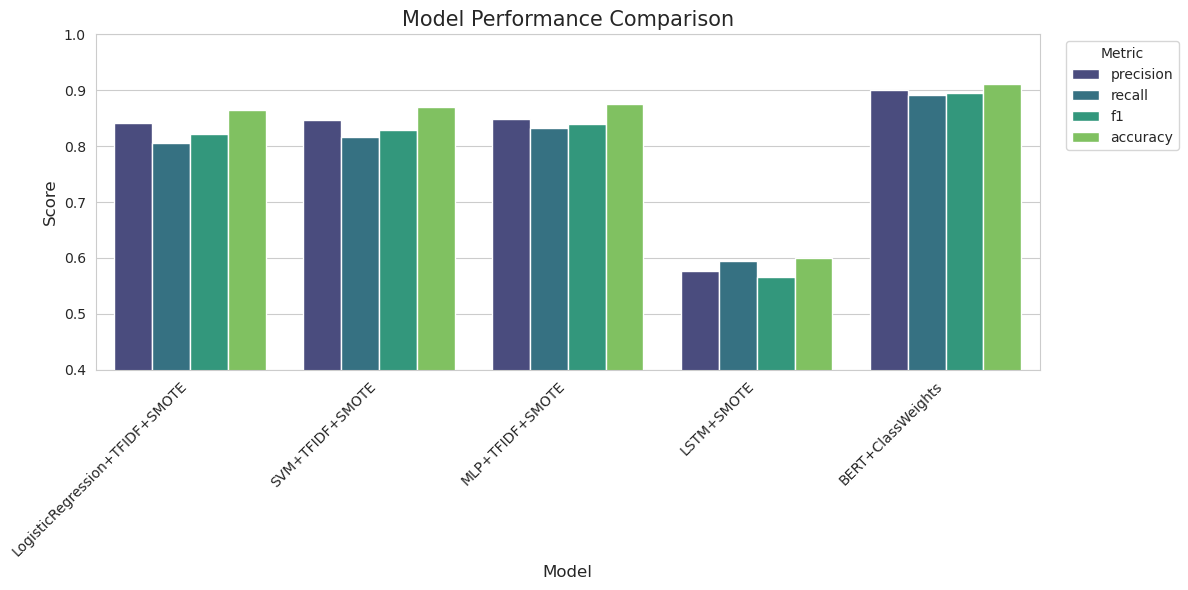

<Figure size 640x480 with 0 Axes>

In [94]:
import seaborn as sns

import matplotlib.pyplot as plt

# Set figure size for better readability
plt.figure(figsize=(12, 6))

# Convert the dataframe to a format suitable for plotting
plot_df = results.reset_index().melt(id_vars='index', value_vars=['precision', 'recall', 'f1', 'accuracy'],
                                      var_name='Metric', value_name='Score')

# Create the grouped bar plot
sns.set_style("whitegrid")
chart = sns.barplot(x='index', y='Score', hue='Metric', data=plot_df, palette='viridis')

# Customize the appearance
plt.title('Model Performance Comparison', fontsize=15)
plt.xlabel('Model', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.ylim(0.4, 1.0)  # Set y-axis range for better visualization
plt.xticks(rotation=45, ha='right')  # Rotate model names for readability
plt.legend(title='Metric', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()

# Show the plot
plt.show()
plt.savefig("model_performance_comparison.pdf", bbox_inches='tight', dpi=300)

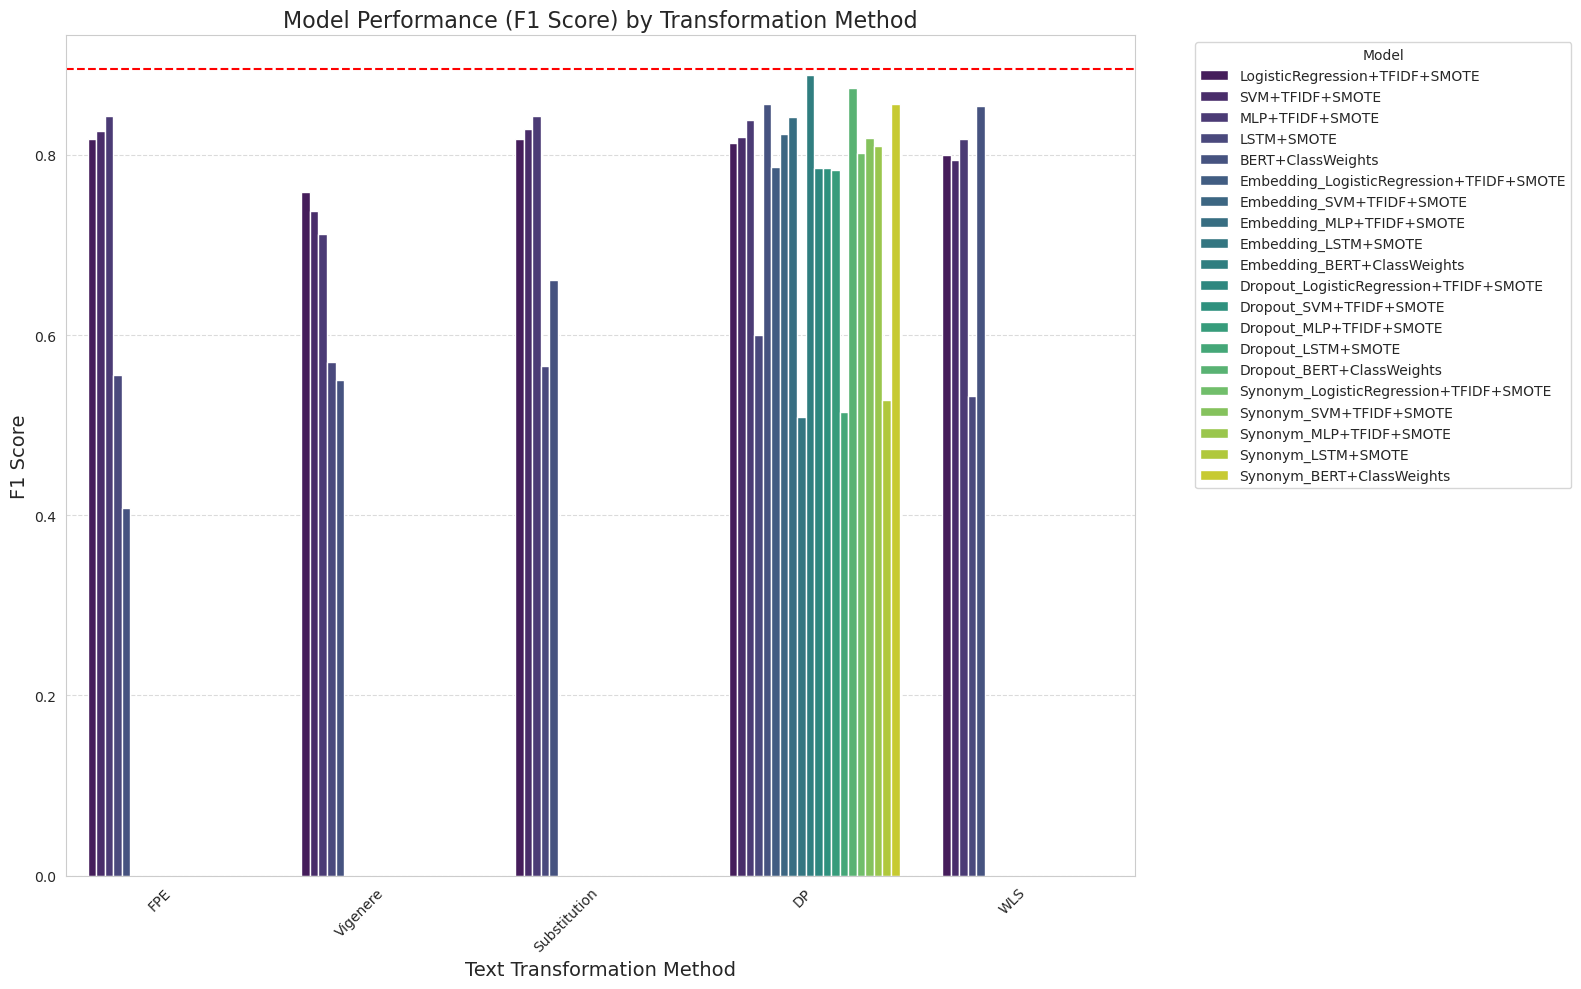

<Figure size 640x480 with 0 Axes>

In [97]:
import seaborn as sns

import matplotlib.pyplot as plt

# Create a figure with adequate size
plt.figure(figsize=(16, 10))

# Extract transformation and model from index and create a new dataframe
plot_data = []
for idx, row in results_all.iterrows():
    parts = idx.split('_', 1)
    transformation = parts[0]
    model = parts[1] if len(parts) > 1 else idx
    plot_data.append({
        'Transformation': transformation,
        'Model': model,
        'F1 Score': row['f1']
    })

plot_df = pd.DataFrame(plot_data)

# Create grouped barplot
sns.barplot(
    x='Transformation', 
    y='F1 Score', 
    hue='Model', 
    data=plot_df,
    palette='viridis'
)

# Customize appearance
plt.title('Model Performance (F1 Score) by Transformation Method', fontsize=16)
plt.xlabel('Text Transformation Method', fontsize=14)
plt.ylabel('F1 Score', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add a horizontal line for the best original model's performance
best_original_f1 = results['f1'].max()
plt.axhline(y=best_original_f1, color='red', linestyle='--', 
           label='Best Original Model Performance')

plt.tight_layout()
plt.show()
plt.savefig("model_performance_by_transformation.pdf", bbox_inches='tight')

/tmp/ipykernel_2938198/3697520672.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


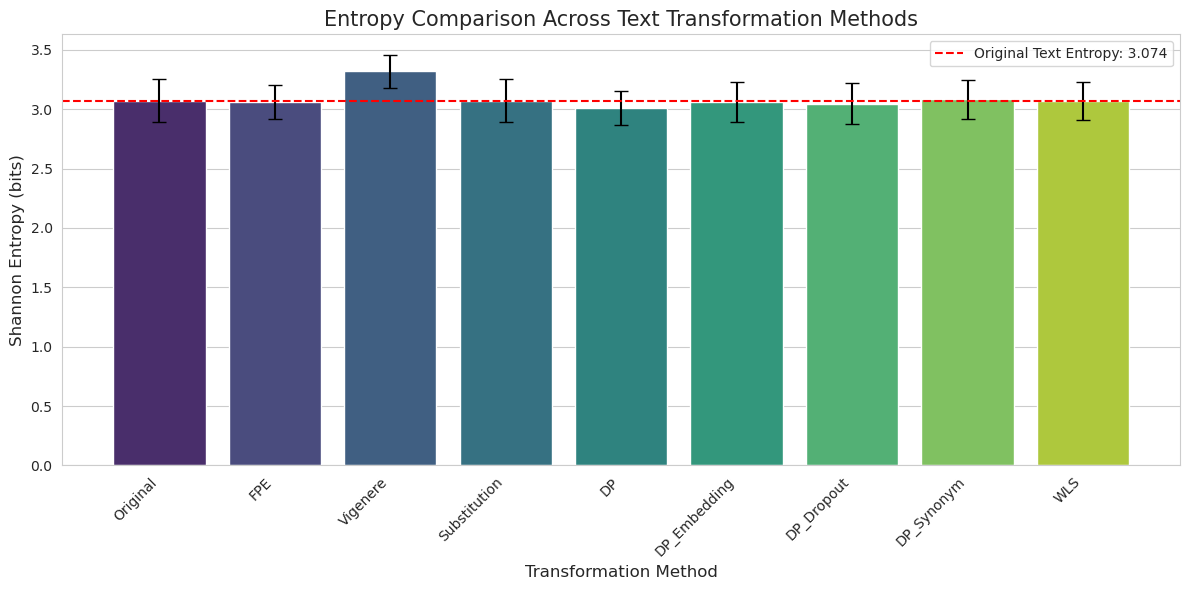

<Figure size 640x480 with 0 Axes>

In [91]:
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt

# Set figure size
plt.figure(figsize=(12, 6))

# Create bar chart
ax = sns.barplot(
    x='Version', 
    y='Mean Entropy',
    data=entropy_results,
    palette='viridis'
)

# Add error bars for std entropy
for i, row in enumerate(entropy_results.iterrows()):
    ax.errorbar(
        i, row[1]['Mean Entropy'], 
        yerr=row[1]['Std Entropy'],
        fmt='none', color='black', capsize=5
    )

# Add a horizontal line at original entropy
original_entropy = entropy_results[entropy_results['Version'] == 'Original']['Mean Entropy'].values[0]
plt.axhline(original_entropy, color='red', linestyle='--', 
           label=f'Original Text Entropy: {original_entropy:.3f}')

# Customize appearance
plt.title('Entropy Comparison Across Text Transformation Methods', fontsize=15)
plt.xlabel('Transformation Method', fontsize=12)
plt.ylabel('Shannon Entropy (bits)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()
plt.savefig("entropy_comparison.pdf", bbox_inches='tight')

In [99]:
# List of dataframes to display
dataframes = {
    "Original": df,
    "Format-Preserving Encryption (FPE)": df_fpe,
    "Vigenere Cipher": df_vigenere,
    "Substitution Cipher": df_substitution,
    "Differential Privacy (DP)": df_dp,
    "Word-Level Substitution (WLS)": df_wls,
    "DP with Embedding Noise": df_dp_embedding,
    "DP with Token Dropout": df_dp_dropout,
    "DP with Synonym Substitution": df_dp_synonym
}

# Display the first 5 rows of each dataframe
for name, dataframe in dataframes.items():
    print(f"\n{'='*80}")
    print(f"{name}:")
    print(f"{'='*80}")
    display(dataframe[['title', 'text', 'stance']].head())


Original:


,title,text,stance
0,Apple is China's bitch,Apple is China's bitch Apple is China's bitch ...,anti-china
1,[Day 1] China Sorrows,[Day 1] China Sorrows [Day 1] China Sorrows Ju...,pro-china
2,Apple decides to take the side of oppression a...,Apple decides to take the side of oppression a...,anti-china
3,#加速主义,"#加速主义 #加速主义 During the reign of trump, make ""a...",pro-china
4,my chinese class wants to thank our professor ...,my chinese class wants to thank our professor ...,pro-china



Format-Preserving Encryption (FPE):


,title,text,stance
0,Apple is China's bitch,Dssoh lv Fklqd'v elwfk Dssoh lv Fklqd'v elwfk ...,anti-china
1,[Day 1] China Sorrows,[Gdb 1] Fklqd Vruurzv [Gdb 1] Fklqd Vruurzv Mx...,pro-china
2,Apple decides to take the side of oppression a...,Dssoh ghflghv wr wdnh wkh vlgh ri rssuhvvlrq d...,anti-china
3,#加速主义,"#ylrf #ylrf Gxulqj wkh uhljq ri wuxps, pdnh ""d...",pro-china
4,my chinese class wants to thank our professor ...,pb fklqhvh fodvv zdqwv wr wkdqn rxu surihvvru ...,pro-china



Vigenere Cipher:


,title,text,stance
0,Apple is China's bitch,Strci bc Gfarc'j fbdgf Strci bc Gfarc'j fbdgf ...,anti-china
1,[Day 1] China Sorrows,[Vea 1] Tlbxe Qgvtfal [New 1] Ulkee Lyvpgau Ay...,pro-china
2,Apple decides to take the side of oppression a...,Strci woggviu ks mkoc llg jmwo sd gtriilcmmf e...,anti-china
3,#加速主义,"#nmqt #zbyg Bmvkek mri pwmie sy dvset, orox ""k...",pro-china
4,my chinese class wants to thank our professor ...,ec eymgowc upcjw pkrrk xq kltxo mmv risyowqgv ...,pro-china



Substitution Cipher:


,title,text,stance
0,Apple is China's bitch,Ubbim la Oxlpu'a jlnox Ubbim la Oxlpu'a jlnox ...,anti-china
1,[Day 1] China Sorrows,[Guk 1] Oxlpu Acffcya [Guk 1] Oxlpu Acffcya Rt...,pro-china
2,Apple decides to take the side of oppression a...,Ubbim gmolgma nc nuzm nxm algm cv cbbfmaalcp u...,anti-china
3,#加速主义,"#加速主义 #加速主义 Gtflps nxm fmlsp cv nftqb, quzm ""u...",pro-china
4,my chinese class wants to thank our professor ...,qk oxlpmam oiuaa yupna nc nxupz ctf bfcvmaacf ...,pro-china



Differential Privacy (DP):


,title,text,stance
0,Apple is China's bitch,foo Apple is foo China's bitch bar Apple is ba...,anti-china
1,[Day 1] China Sorrows,[Day 1] foo China Sorrows [Day baz 1] foo Chin...,pro-china
2,Apple decides to take the side of oppression a...,baz Apple bar decides baz to baz take bar the ...,anti-china
3,#加速主义,#加速主义 bar #加速主义 foo During the foo reign baz o...,pro-china
4,my chinese class wants to thank our professor ...,my foo chinese bar class baz wants baz to than...,pro-china



Word-Level Substitution (WLS):


,title,text,stance
0,Apple is China's bitch,Apple is China's bitch Apple comprise China's ...,anti-china
1,[Day 1] China Sorrows,[Day 1] China Sorrows [Day 1] China Sorrows on...,pro-china
2,Apple decides to take the side of oppression a...,Apple decides to take in the side of oppressiv...,anti-china
3,#加速主义,"#加速主义 加速主义 During the reign of trump, make ""ac...",pro-china
4,my chinese class wants to thank our professor ...,my chinese class wants to thank our prof - wha...,pro-china



DP with Embedding Noise:


,title,text,stance
0,Apple is China's bitch,Apple in is China's bitch Apple is China's and...,anti-china
1,[Day 1] China Sorrows,[Day 1] China Sorrows [Day 1] China So rrows f...,pro-china
2,Apple decides to take the side of oppression a...,Apple decides to take the side of oppression a...,anti-china
3,#加速主义,"#加速 主义 #加速主义 During the reign of trump, make ""...",pro-china
4,my chinese class wants to thank our professor ...,my chinese class wants to thank our professor ...,pro-china



DP with Token Dropout:


,title,text,stance
0,Apple is China's bitch,Apple is China's bitch Apple is China's bitch ...,anti-china
1,[Day 1] China Sorrows,[Day 1] China Sorrows [Day China Just a quick ...,pro-china
2,Apple decides to take the side of oppression a...,Apple decides to take the side of oppression s...,anti-china
3,#加速主义,"#加速主义 During the reign make ""acceleration"", ac...",pro-china
4,my chinese class wants to thank our professor ...,my wants to thank our professor - what gift sh...,pro-china



DP with Synonym Substitution:


,title,text,stance
0,Apple is China's bitch,Apple is China's bitch Apple is China's bellya...,anti-china
1,[Day 1] China Sorrows,[Day 1] Communist China Sorrows [Day 1] China ...,pro-china
2,Apple decides to take the side of oppression a...,Apple settle to take the incline of subjugatio...,anti-china
3,#加速主义,"#加速主义 #加速主义 During the reign of trump, constit...",pro-china
4,my chinese class wants to thank our professor ...,my Taiwanese class wants to thank our professo...,pro-china


In [ ]:

# 




(                                               title  \
 0                             Apple is China's bitch   
 1                              [Day 1] China Sorrows   
 2  Apple decides to take the side of oppression a...   
 3                                              #加速主义   
 4  my chinese class wants to thank our professor ...   
 
                                             selftext      stance  \
 0  Apple is China's bitch   \n[Apple made secret ...  anti-china   
 1  [Day 1] China Sorrows Just a quick pre-text. T...   pro-china   
 2  Apple decides to take the side of oppression a...  anti-china   
 3  #加速主义 During the reign of trump, make "acceler...   pro-china   
 4  my chinese class wants to thank our professor ...   pro-china   
 
                                                 text  label  
 0  Dssoh lv Fklqd'v elwfk Dssoh lv Fklqd'v elwfk ...      0  
 1  [Gdb 1] Fklqd Vruurzv [Gdb 1] Fklqd Vruurzv Mx...      1  
 2  Dssoh ghflghv wr wdnh wkh vlgh ri rssuhvvlrq d.